In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, split
from pyspark import SparkContext
from pyspark.sql.functions import regexp_replace


creamos sesion para usar pyspark


In [2]:
SpSesion = SparkSession \
          .builder \
          .appName('etl') \
          .getOrCreate() 

Creamos la sesion de contexto

In [3]:
SpContext = SpSesion.sparkContext

vamos a cargar datos


In [4]:
path = 'steam_games.json.gz'

In [5]:
dataset = SpSesion.read.json(path)

Vamos a pasar a explorar el archivo y ver de que se trata, tipos de columnas variables  etc


In [6]:
print('los tipod de tados son  para cada columna \n',dataset.dtypes)
print()
print(f'tiene {len(dataset.columns)} columnas ')
print('las columnas son \n',dataset.columns)
print()
print(f'el dataset tiene {dataset.count()} filas')
print()



los tipod de tados son  para cada columna 
 [('app_name', 'string'), ('developer', 'string'), ('early_access', 'string'), ('genres', 'string'), ('id', 'string'), ('price', 'string'), ('publisher', 'string'), ('release_date', 'string'), ('reviews_url', 'string'), ('specs', 'string'), ('tags', 'string'), ('title', 'string'), ('url', 'string')]

tiene 13 columnas 
las columnas son 
 ['app_name', 'developer', 'early_access', 'genres', 'id', 'price', 'publisher', 'release_date', 'reviews_url', 'specs', 'tags', 'title', 'url']

el dataset tiene 120445 filas



In [7]:
dataset.printSchema()

root
 |-- app_name: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- early_access: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- id: string (nullable = true)
 |-- price: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- reviews_url: string (nullable = true)
 |-- specs: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)



Vamos a verlo impreso en pantalla

In [8]:
print(dataset.show())

+--------+---------+------------+------+-----+-----+---------+------------+-----------+-----+-----+-----+-----+
|app_name|developer|early_access|genres|   id|price|publisher|release_date|reviews_url|specs| tags|title|  url|
+--------+---------+------------+------+-----+-----+---------+------------+-----------+-----+-----+-----+-----+
|   "NaN"|    "NaN"|       "NaN"| "NaN"|"NaN"|"NaN"|    "NaN"|       "NaN"|      "NaN"|"NaN"|"NaN"|"NaN"|"NaN"|
|   "NaN"|    "NaN"|       "NaN"| "NaN"|"NaN"|"NaN"|    "NaN"|       "NaN"|      "NaN"|"NaN"|"NaN"|"NaN"|"NaN"|
|   "NaN"|    "NaN"|       "NaN"| "NaN"|"NaN"|"NaN"|    "NaN"|       "NaN"|      "NaN"|"NaN"|"NaN"|"NaN"|"NaN"|
|   "NaN"|    "NaN"|       "NaN"| "NaN"|"NaN"|"NaN"|    "NaN"|       "NaN"|      "NaN"|"NaN"|"NaN"|"NaN"|"NaN"|
|   "NaN"|    "NaN"|       "NaN"| "NaN"|"NaN"|"NaN"|    "NaN"|       "NaN"|      "NaN"|"NaN"|"NaN"|"NaN"|"NaN"|
|   "NaN"|    "NaN"|       "NaN"| "NaN"|"NaN"|"NaN"|    "NaN"|       "NaN"|      "NaN"|"NaN"|"NaN"|"NaN"

In [9]:
cantidad_filas = dataset.count()

print (cantidad_filas)

120445


vamos a limpiar las filas que tengan "NaN" en la columna id dado que no queremos la información de filas sin id, dado que la columna id es la mas relevante a mi parecer dentro del dataset.

In [10]:
nan_count = dataset.filter(col('id') == '"NaN"').count()

print (nan_count)

88312


In [11]:
dataset = dataset.filter(col('id') != '"NaN"')
dataset.show(truncate=False)

+------------------------------------------------------------------------------+------------------------------+------------+-------------------------------------------------------+------+------------+------------------------------+------------+-------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------

Dropeamos las columnas que no usaremos

In [12]:
dataset = dataset.drop('price')
dataset = dataset.drop('early_access')
dataset = dataset.drop('reviews_url')
dataset = dataset.drop('url')
dataset = dataset.drop('specs')
dataset = dataset.drop('tags')
dataset = dataset.drop('app_name')
dataset = dataset.drop('publisher')

In [13]:
dataset.show()

+--------------------+--------------------+------+------------+--------------------+
|           developer|              genres|    id|release_date|               title|
+--------------------+--------------------+------+------------+--------------------+
|           Kotoshiro|["Action","Casual...|761140|  2018-01-04| Lost Summoner Kitty|
|    Secret Level SRL|["Free to Play","...|643980|  2018-01-04|           Ironbound|
|        Poolians.com|["Casual","Free t...|670290|  2017-07-24|Real Pool 3D - Po...|
|            彼岸领域|["Action","Advent...|767400|  2017-12-07|          弹炸人2222|
|               "NaN"|               "NaN"|773570|       "NaN"|               "NaN"|
| Trickjump Games Ltd|["Action","Advent...|772540|  2018-01-04|Battle Royale Tra...|
|Poppermost Produc...|["Free to Play","...|774276|  2018-01-04|SNOW - All Access...|
|Poppermost Produc...|["Free to Play","...|774277|  2018-01-04|SNOW - All Access...|
|Poppermost Produc...|["Free to Play","...|774278|  2018-01-04|SNOW - Al

limpiamos de la fila title los NaN

In [14]:
print( dataset.filter(col('title') == '"NaN"').count())

dataset = dataset.filter(col('title') != '"NaN"')


2049


In [15]:
nan_count_genres= dataset.filter(col('genres') == '"NaN"').count()
print(nan_count_genres)
dataset = dataset.filter(col('genres') != '"NaN"')
print(nan_count_genres)

1234
1234


In [16]:
df = dataset

In [17]:
df.show(truncate=False)

+------------------------------+-------------------------------------------------------+------+------------+------------------------------------------------------------------------------+
|developer                     |genres                                                 |id    |release_date|title                                                                         |
+------------------------------+-------------------------------------------------------+------+------------+------------------------------------------------------------------------------+
|Kotoshiro                     |["Action","Casual","Indie","Simulation","Strategy"]    |761140|2018-01-04  |Lost Summoner Kitty                                                           |
|Secret Level SRL              |["Free to Play","Indie","RPG","Strategy"]              |643980|2018-01-04  |Ironbound                                                                     |
|Poolians.com                  |["Casual","Free to Play","In

pasamos nuestro dataframe a pandas ahora que hemos achicado el tamaño de nuestro DF y nuestra pc no explota


In [18]:
df = dataset.toPandas()

In [19]:
df

,developer,genres,id,release_date,title
0,Kotoshiro,"[""Action"",""Casual"",""Indie"",""Simulation"",""Strat...",761140,2018-01-04,Lost Summoner Kitty
1,Secret Level SRL,"[""Free to Play"",""Indie"",""RPG"",""Strategy""]",643980,2018-01-04,Ironbound
2,Poolians.com,"[""Casual"",""Free to Play"",""Indie"",""Simulation"",...",670290,2017-07-24,Real Pool 3D - Poolians
3,彼岸领域,"[""Action"",""Adventure"",""Casual""]",767400,2017-12-07,弹炸人2222
4,Trickjump Games Ltd,"[""Action"",""Adventure"",""Simulation""]",772540,2018-01-04,Battle Royale Trainer
...,...,...,...,...,...
28845,Bidoniera Games,"[""Action"",""Adventure"",""Casual"",""Indie""]",745400,2018-01-04,Kebab it Up!
28846,"Nikita ""Ghost_RUS""","[""Casual"",""Indie"",""Simulation"",""Strategy""]",773640,2018-01-04,Colony On Mars
28847,Sacada,"[""Casual"",""Indie"",""Strategy""]",733530,2018-01-04,LOGistICAL: South Africa
28848,Laush Dmitriy Sergeevich,"[""Indie"",""Racing"",""Simulation""]",610660,2018-01-04,Russian Roads


comienzo la limpieza y preparacion para convertir en variables dummies  la columna genero ya que la misma tendra un factor decisivo en la puesta en marcha
de nuestra Api

In [20]:
df['genres'] = df['genres'].str.strip('[]')
df['genres'] = df['genres'].str.replace('"', '')

In [21]:
df

,developer,genres,id,release_date,title
0,Kotoshiro,"Action,Casual,Indie,Simulation,Strategy",761140,2018-01-04,Lost Summoner Kitty
1,Secret Level SRL,"Free to Play,Indie,RPG,Strategy",643980,2018-01-04,Ironbound
2,Poolians.com,"Casual,Free to Play,Indie,Simulation,Sports",670290,2017-07-24,Real Pool 3D - Poolians
3,彼岸领域,"Action,Adventure,Casual",767400,2017-12-07,弹炸人2222
4,Trickjump Games Ltd,"Action,Adventure,Simulation",772540,2018-01-04,Battle Royale Trainer
...,...,...,...,...,...
28845,Bidoniera Games,"Action,Adventure,Casual,Indie",745400,2018-01-04,Kebab it Up!
28846,"Nikita ""Ghost_RUS""","Casual,Indie,Simulation,Strategy",773640,2018-01-04,Colony On Mars
28847,Sacada,"Casual,Indie,Strategy",733530,2018-01-04,LOGistICAL: South Africa
28848,Laush Dmitriy Sergeevich,"Indie,Racing,Simulation",610660,2018-01-04,Russian Roads


funcion que nos creara de nuestra columna genero cierta cantidad de columnas como generos exista para luego usar con nuestras librerias de Machine Learning

In [22]:
def crear_columnas(df):
    dummies = df['genres'].str.get_dummies(sep=',')
    df = pd.concat([df, dummies], axis=1)
    return df

In [23]:
df=crear_columnas(df)

In [24]:
df

,developer,genres,id,release_date,title,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
0,Kotoshiro,"Action,Casual,Indie,Simulation,Strategy",761140,2018-01-04,Lost Summoner Kitty,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,Secret Level SRL,"Free to Play,Indie,RPG,Strategy",643980,2018-01-04,Ironbound,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,Poolians.com,"Casual,Free to Play,Indie,Simulation,Sports",670290,2017-07-24,Real Pool 3D - Poolians,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,彼岸领域,"Action,Adventure,Casual",767400,2017-12-07,弹炸人2222,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Trickjump Games Ltd,"Action,Adventure,Simulation",772540,2018-01-04,Battle Royale Trainer,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,Bidoniera Games,"Action,Adventure,Casual,Indie",745400,2018-01-04,Kebab it Up!,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
28846,"Nikita ""Ghost_RUS""","Casual,Indie,Simulation,Strategy",773640,2018-01-04,Colony On Mars,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
28847,Sacada,"Casual,Indie,Strategy",733530,2018-01-04,LOGistICAL: South Africa,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
28848,Laush Dmitriy Sergeevich,"Indie,Racing,Simulation",610660,2018-01-04,Russian Roads,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


hacemos una descripcion rapita de la cantidad de elementos que presenta cada  columna de acuerdo a su genero

In [25]:
count_ones = df.sum()
print(count_ones)

developer                    KotoshiroSecret Level SRLPoolians.com彼岸领域Trick...
genres                       Action,Casual,Indie,Simulation,StrategyFree to...
id                           7611406439806702907674007725407742767742777742...
release_date                 2018-01-042018-01-042017-07-242017-12-072018-0...
title                        Lost Summoner KittyIronboundReal Pool 3D - Poo...
Accounting                                                                   7
Action                                                                   11319
Adventure                                                                 8242
Animation &amp; Modeling                                                   183
Audio Production                                                            93
Casual                                                                    8282
Design &amp; Illustration                                                  460
Early Access                                        

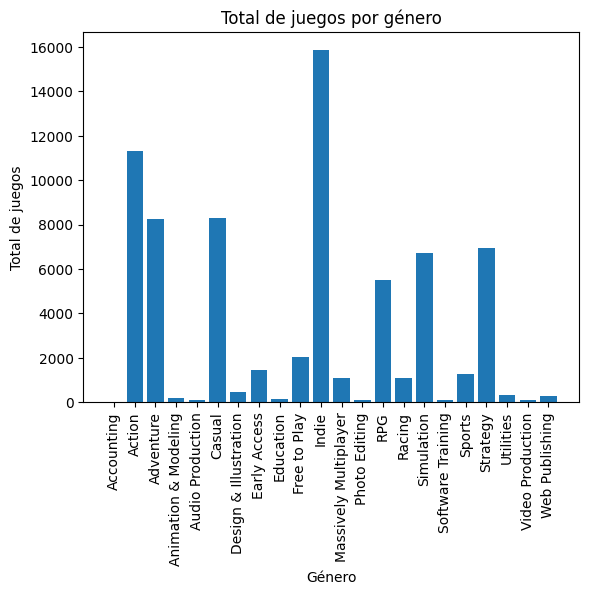

In [26]:



generos = ['Accounting', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Early Access', 'Education', 'Free to Play', 'Indie', 'Massively Multiplayer', 'Photo Editing', 'RPG', 'Racing', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities', 'Video Production', 'Web Publishing']
juegos = [7, 11319, 8242, 183, 93, 8282, 460, 1462, 125, 2031, 15857, 1108, 77, 5479, 1083, 6699, 105, 1257, 6957, 340, 116, 268]


plt.bar(generos, juegos)
plt.xlabel('Género')
plt.ylabel('Total de juegos')
plt.title('Total de juegos por género')
plt.xticks(rotation=90) 
plt.show()


Procedo a dropear las columnas que no representan un genero, son mas un subgenero dentro del gaming , haciendo nuestro sistema de recomendacion por Machine Learning mas Eficiente


In [27]:
df = df.drop('Photo Editing',axis=1)
df = df.drop('Video Production',axis=1)
df = df.drop('Web Publishing',axis=1)
df = df.drop('Utilities',axis=1)
df = df.drop('Early Access',axis=1)
df = df.drop('Design &amp; Illustration',axis=1)
df = df.drop('Software Training',axis=1)
df = df.drop('Free to Play',axis=1)
df = df.drop('Massively Multiplayer',axis=1)
df = df.drop('Audio Production',axis=1)
df = df.drop('genres',axis=1)
df = df.drop('Accounting',axis=1)
df = df.drop('Animation &amp; Modeling',axis=1)


In [28]:

df

,developer,id,release_date,title,Action,Adventure,Casual,Education,Indie,RPG,Racing,Simulation,Sports,Strategy
0,Kotoshiro,761140,2018-01-04,Lost Summoner Kitty,1,0,1,0,1,0,0,1,0,1
1,Secret Level SRL,643980,2018-01-04,Ironbound,0,0,0,0,1,1,0,0,0,1
2,Poolians.com,670290,2017-07-24,Real Pool 3D - Poolians,0,0,1,0,1,0,0,1,1,0
3,彼岸领域,767400,2017-12-07,弹炸人2222,1,1,1,0,0,0,0,0,0,0
4,Trickjump Games Ltd,772540,2018-01-04,Battle Royale Trainer,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,Bidoniera Games,745400,2018-01-04,Kebab it Up!,1,1,1,0,1,0,0,0,0,0
28846,"Nikita ""Ghost_RUS""",773640,2018-01-04,Colony On Mars,0,0,1,0,1,0,0,1,0,1
28847,Sacada,733530,2018-01-04,LOGistICAL: South Africa,0,0,1,0,1,0,0,0,0,1
28848,Laush Dmitriy Sergeevich,610660,2018-01-04,Russian Roads,0,0,0,0,1,0,1,1,0,0


Vamos a trabajar sobre la columna Release data ya que la usaremos para las consultas de nuestra api...  la cual queremos darle la forma para poder usar  Fechas convertir a al tipo de dato Datetime

limpiamos de nulos nuestro Release Date

In [29]:
df['release_date'].replace("", np.nan, inplace=True)    
df.dropna(subset=['release_date'], inplace=True)

verificamos si quedan nulos


In [30]:
num_nulos = df['release_date'].isnull().sum()

print(f"El DataFrame tiene {num_nulos} valores nulos en total.")


El DataFrame tiene 0 valores nulos en total.


aun debemos verificar que toda la columna posea las caracteristicas similares para la conversion y de ser afirmativo, verificamos la cantidad de filas que tienen ese problema

In [31]:

df['temp'] = pd.to_datetime(df['release_date'], errors='coerce')
num_invalid = df['temp'].isnull().sum()
print(f"La columna 'release_date' tiene {num_invalid} valores con un formato inválido.")
df.drop('temp', axis=1, inplace=True)


La columna 'release_date' tiene 303 valores con un formato inválido.


pasamos a convertir la columna con el formato deseado, a posteriori eliminamos las filas que son NaT

In [32]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce')
df = df[df['release_date'].notna()]

In [33]:
df

,developer,id,release_date,title,Action,Adventure,Casual,Education,Indie,RPG,Racing,Simulation,Sports,Strategy
0,Kotoshiro,761140,2018-01-04,Lost Summoner Kitty,1,0,1,0,1,0,0,1,0,1
1,Secret Level SRL,643980,2018-01-04,Ironbound,0,0,0,0,1,1,0,0,0,1
2,Poolians.com,670290,2017-07-24,Real Pool 3D - Poolians,0,0,1,0,1,0,0,1,1,0
3,彼岸领域,767400,2017-12-07,弹炸人2222,1,1,1,0,0,0,0,0,0,0
4,Trickjump Games Ltd,772540,2018-01-04,Battle Royale Trainer,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,Bidoniera Games,745400,2018-01-04,Kebab it Up!,1,1,1,0,1,0,0,0,0,0
28846,"Nikita ""Ghost_RUS""",773640,2018-01-04,Colony On Mars,0,0,1,0,1,0,0,1,0,1
28847,Sacada,733530,2018-01-04,LOGistICAL: South Africa,0,0,1,0,1,0,0,0,0,1
28848,Laush Dmitriy Sergeevich,610660,2018-01-04,Russian Roads,0,0,0,0,1,0,1,1,0,0


In [34]:
df['id']=df['id'].astype(int) # cambiamos el tipo de dato de esta columna

C:\Users\coco\AppData\Local\Temp\ipykernel_7384\3523404650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id']=df['id'].astype(int) # cambiamos el tipo de dato de esta columna


In [35]:
print(df.dtypes)

developer               object
id                       int32
release_date    datetime64[ns]
title                   object
Action                   int64
Adventure                int64
Casual                   int64
Education                int64
Indie                    int64
RPG                      int64
Racing                   int64
Simulation               int64
Sports                   int64
Strategy                 int64
dtype: object


In [36]:
df

,developer,id,release_date,title,Action,Adventure,Casual,Education,Indie,RPG,Racing,Simulation,Sports,Strategy
0,Kotoshiro,761140,2018-01-04,Lost Summoner Kitty,1,0,1,0,1,0,0,1,0,1
1,Secret Level SRL,643980,2018-01-04,Ironbound,0,0,0,0,1,1,0,0,0,1
2,Poolians.com,670290,2017-07-24,Real Pool 3D - Poolians,0,0,1,0,1,0,0,1,1,0
3,彼岸领域,767400,2017-12-07,弹炸人2222,1,1,1,0,0,0,0,0,0,0
4,Trickjump Games Ltd,772540,2018-01-04,Battle Royale Trainer,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,Bidoniera Games,745400,2018-01-04,Kebab it Up!,1,1,1,0,1,0,0,0,0,0
28846,"Nikita ""Ghost_RUS""",773640,2018-01-04,Colony On Mars,0,0,1,0,1,0,0,1,0,1
28847,Sacada,733530,2018-01-04,LOGistICAL: South Africa,0,0,1,0,1,0,0,0,0,1
28848,Laush Dmitriy Sergeevich,610660,2018-01-04,Russian Roads,0,0,0,0,1,0,1,1,0,0


Comenzamos con el sistema de recomendacion!!! de MAchine LEarning preparamos  las columnas a  ser usadas

In [37]:
df

,developer,id,release_date,title,Action,Adventure,Casual,Education,Indie,RPG,Racing,Simulation,Sports,Strategy
0,Kotoshiro,761140,2018-01-04,Lost Summoner Kitty,1,0,1,0,1,0,0,1,0,1
1,Secret Level SRL,643980,2018-01-04,Ironbound,0,0,0,0,1,1,0,0,0,1
2,Poolians.com,670290,2017-07-24,Real Pool 3D - Poolians,0,0,1,0,1,0,0,1,1,0
3,彼岸领域,767400,2017-12-07,弹炸人2222,1,1,1,0,0,0,0,0,0,0
4,Trickjump Games Ltd,772540,2018-01-04,Battle Royale Trainer,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28845,Bidoniera Games,745400,2018-01-04,Kebab it Up!,1,1,1,0,1,0,0,0,0,0
28846,"Nikita ""Ghost_RUS""",773640,2018-01-04,Colony On Mars,0,0,1,0,1,0,0,1,0,1
28847,Sacada,733530,2018-01-04,LOGistICAL: South Africa,0,0,1,0,1,0,0,0,0,1
28848,Laush Dmitriy Sergeevich,610660,2018-01-04,Russian Roads,0,0,0,0,1,0,1,1,0,0


# Analisis de recomendacion de juegos Usando Cosine_similarity 

Intente aislar el dataframe  df_similarity para tener armado el Datafrme y evitar el uso dentro deploy, pero mi pc se queda muy corta...., otra opcion seria usar Databrics, pero primero deseo dejar El proyecto para entregar y si tengo tiempo Antes del Deadline me gustaria hacerlo! 

tener en cuenta que  habia dops opciones de hacer la consulta yo me oriente hacerla  recomendacion item item

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
df.set_index("id", inplace=True)
columnas_numericas = df.select_dtypes(include=['number'])  # aplico un standard scaler a las columnas numericas el indice al cual seteamos como tal esta fuera de dichas

scaler = StandardScaler()
columnas_numericas_normalizadas = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns, index=columnas_numericas.index)
similarity_matrix = cosine_similarity(columnas_numericas_normalizadas)
df_similarity = pd.DataFrame(similarity_matrix, index=columnas_numericas.index, columns=columnas_numericas.index)

funcion de consulta

In [61]:
def recommend_games(game_index, n=5):
    game_row = df_similarity.loc[game_index]
    similar_games = game_row.sort_values(ascending=False).index[1:n+1]
    recommended_game_titles = []
    for game_id in similar_games:
        recommended_game_titles.append(df.loc[id, "title"])

    return recommended_game_titles
    
    

In [62]:
game_id =610660

recommended_games = recommend_games(game_id, n=5)
print(f"Juegos recomendados para '{game_id}': {recommended_games}")


KeyError: 575400

Grabo el archivo final que lo comento para evitar seguir sacando archivos

In [41]:
#df.to_csv('steam_final.csv', index=False)

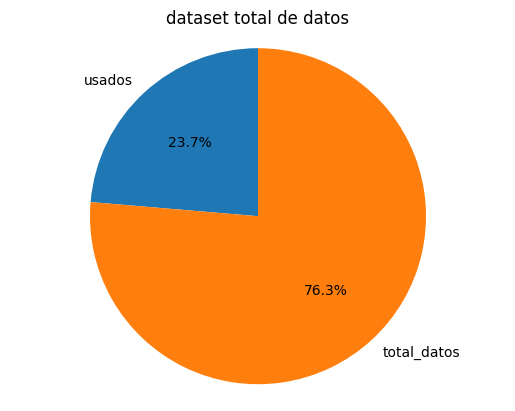

In [42]:

total = 120664
resto = 28547
otro = total - resto


porcentaje_resto = (resto/total)*100
porcentaje_otro = (otro/total)*100
labels = ['usados', 'total_datos']
sizes = [porcentaje_resto, porcentaje_otro]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
plt.title('dataset total de datos')
plt.show()

dejor el indice como estaba originalmente el dataframe

In [43]:
df = df.reset_index(drop=True)